In [ ]:
!nvidia-smi

Sat Jul 27 21:19:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0              32W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Importing Helper Functions

In [ ]:

# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2024-07-27 21:19:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.3’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-07-27 21:19:07 (14.6 MB/s) - ‘helper_functions.py.3’ saved [10246/10246]



## Getting Data
We saw in the previous notebook that we could get great results with only 10% of the training data using transfer learning with TensorFlow Hub.

In this notebook, we're going to continue to work with smaller subsets of the data, except this time we'll have a look at how we can use the in-built pretrained models within the `tf.keras.applications` module as well as how to fine-tune them to our own custom dataset.

We'll also practice using a new but similar dataloader function to what we've used before, image_dataset_from_directory() which is part of the tf.keras.utils module.

Finally, we'll also be practicing using the [Keras Functional API](https://keras.io/guides/functional_api/) for building deep learning models. The Functional API is a more flexible way to create models than the tf.keras.Sequential API.

We'll explore each of these in more detail as we go.

Let's start by downloading some data.

In [ ]:
# Get 10% of training data data of 10 classes of food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-07-27 21:19:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.250.141.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.3’

10_food_classes_10_ 100%[===================>] 160.74M   278MB/s    in 0.6s    

2024-07-27 21:19:10 (278 MB/s) - ‘10_food_classes_10_percent.zip.3’ saved [168546183/168546183]



In [ ]:
# Walk through 10 percent data directory and list number of files
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test

In [ ]:
# Create training and test directory
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

Now we've got some image data, we need a way of loading it into a TensorFlow compatible format.

Previously, we've used the `ImageDataGenerator` class.

However, as of August 2023, this class is deprecated and isn't recommended for future usage (it's too slow).

Because of this, we'll move onto using `tf.keras.utils.image_dataset_from_directory()`.

This method expects image data in the following file format:
Example of file structure

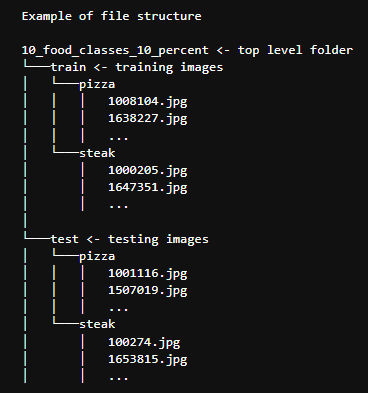


One of the main benefits of using `tf.keras.prepreprocessing.image_dataset_from_directory()` rather than ImageDataGenerator is that it creates a `tf.data.Dataset` object rather than a generator.

The main advantage of this is the `tf.data.Dataset` API is much more efficient (faster) than the `ImageDataGenerator` API which is paramount for larger datasets.

In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            batch_size = BATCH_SIZE,
                                                                            label_mode = "categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                image_size = IMG_SIZE,
                                                                batch_size = BATCH_SIZE,
                                                                label_mode = "categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Wonderful! Looks like our dataloaders have found the correct number of images for each dataset.

For now, the main parameters we're concerned about in the image_dataset_from_directory() funtion are:

- `directory` - the filepath of the target directory we're loading images in from.
- `image_size` - the target size of the images we're going to load in (height, width).
- `batch_size` - the batch size of the images we're going to load in. For example if the batch_size is 32 (the default), batches of 32 images and labels at a time will be passed to the model.

There are more we could play around with if we needed to in the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory).

If we check the training data datatype we should see it as a `BatchDataset` with shapes relating to our data.

In [ ]:
# look at the training dataset
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>
In the above output:

- `(None, 224, 224, 3)` refers to the tensor shape of our images where None is the batch size, 224 is the height (and width) and 3 is the color channels (red, green, blue).
- `(None, 10)` refers to the tensor shape of the labels where None is the batch size and 10 is the number of possible labels (the 10 different food classes).
- Both image tensors and labels are of the datatype `tf.float32`.
The `batch_size` is `None` due to it only being used during model training. You can think of `None` as a placeholder waiting to be filled with the `batch_size` parameter from `image_dataset_from_directory()`.

Another benefit of using the `tf.data.Dataset` API are the assosciated methods which come with it.

For example, if we want to find the name of the classes we were working with, we could use the `class_names` attribute.

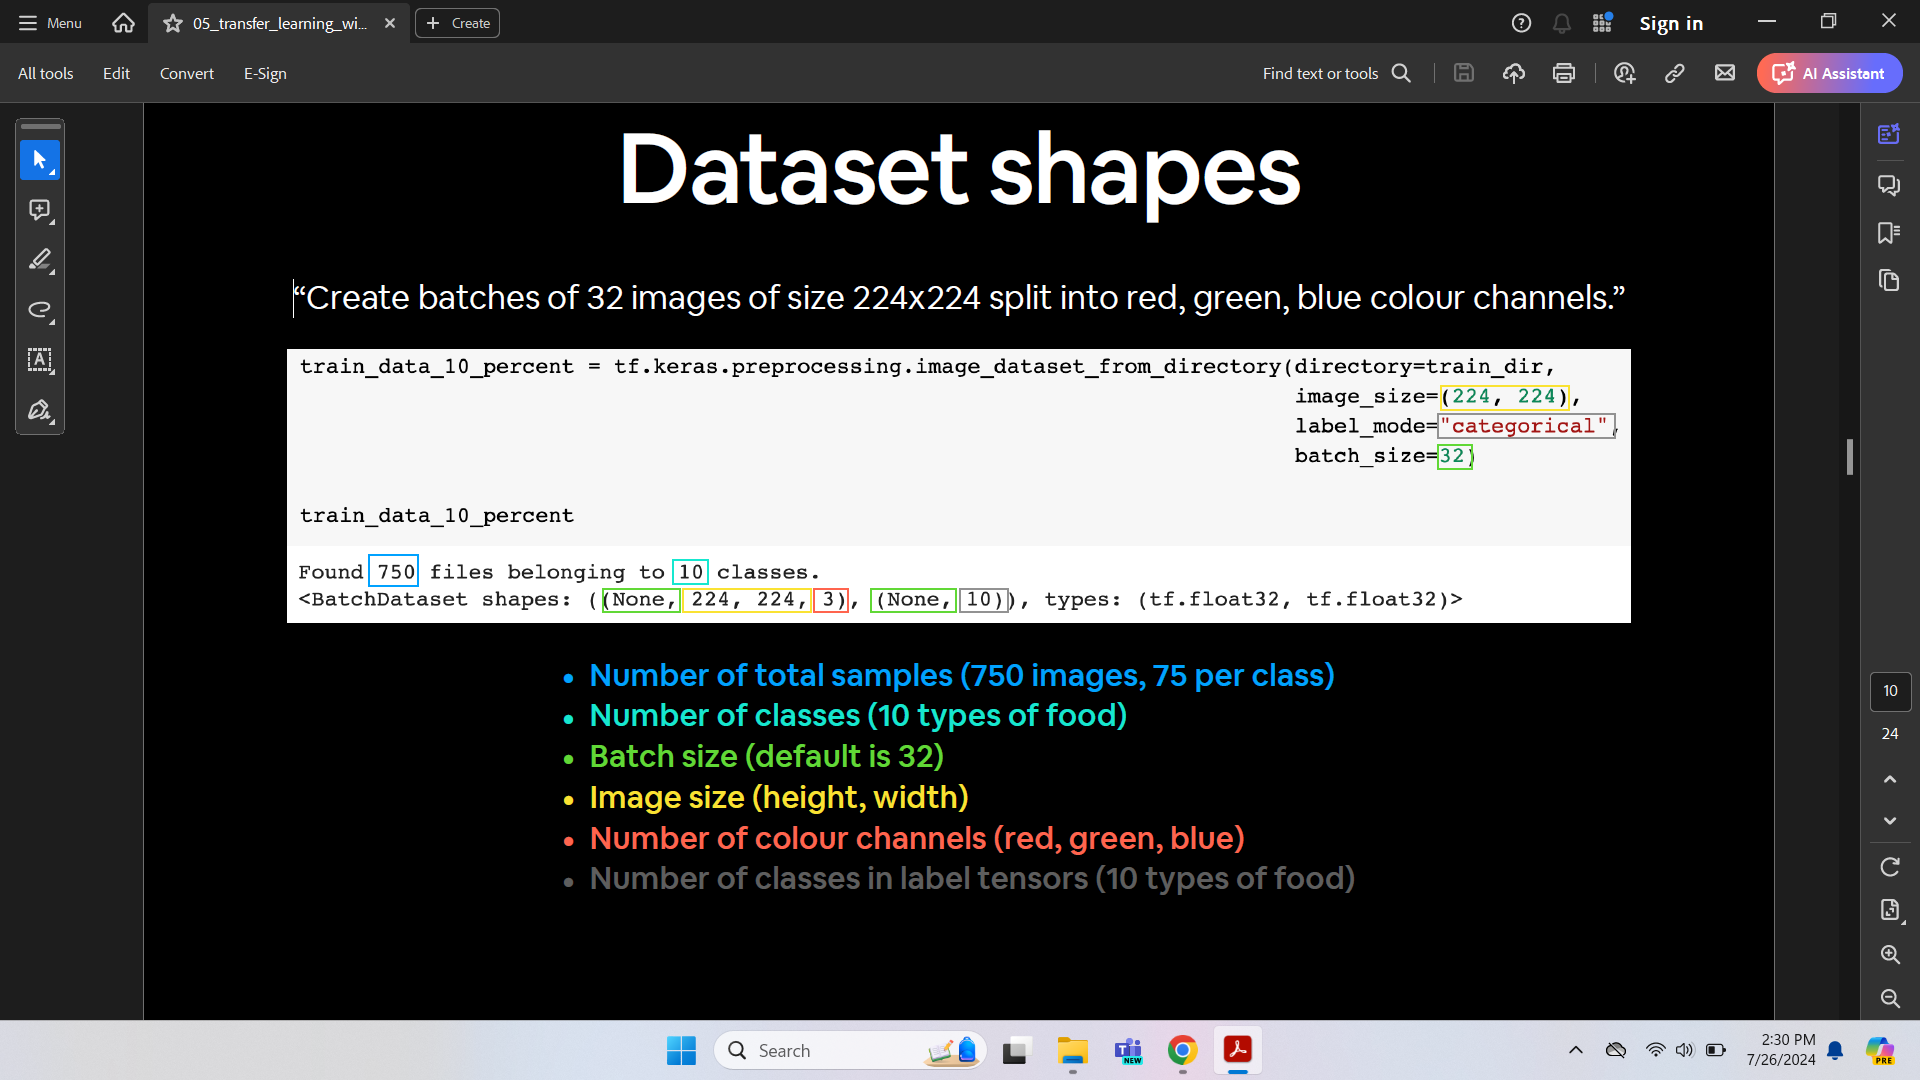

In [ ]:
# look at the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

Or if we wanted to see an example batch of data, we could use the `take()` method.

In [ ]:
# see an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

  ...

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
   [0

## Modelling Experiments in this notebook

- Model 0 (baseline)
  - data: 10 classes of food101 data (random 10% training data only)
  - Preprocessing: None
  - Model: Feature Extractor (EfficientNetB0 pre-trained on Imagenet, all layers frozen) with no top


- Model 1
  - data: 10 classes of food101 data (random 1% training data only)
  - preprocessing: random flip, rotation zoom, height, width, data augmentation
  - model: Same as model 0


- Model 2
  - data: Same as Model 0
  - preprocessing: same as Model 1
  - Model: same as Model 0


- Model 3
  - data: Same as Model 0
  - PreProcessing: Same as Model 1
  - Model: Fine-tuning (efficientnetB0 pre-trained on Imagenet) with top layer trained on custom data, top 10 layers unfrozen.


- Model 4
  - data: 10 classes of Food101 data (100% training data)
  - Preprocessing: Same as Model 1
  - Model: Same as Model 3

## Keras Sequential vs Functional API

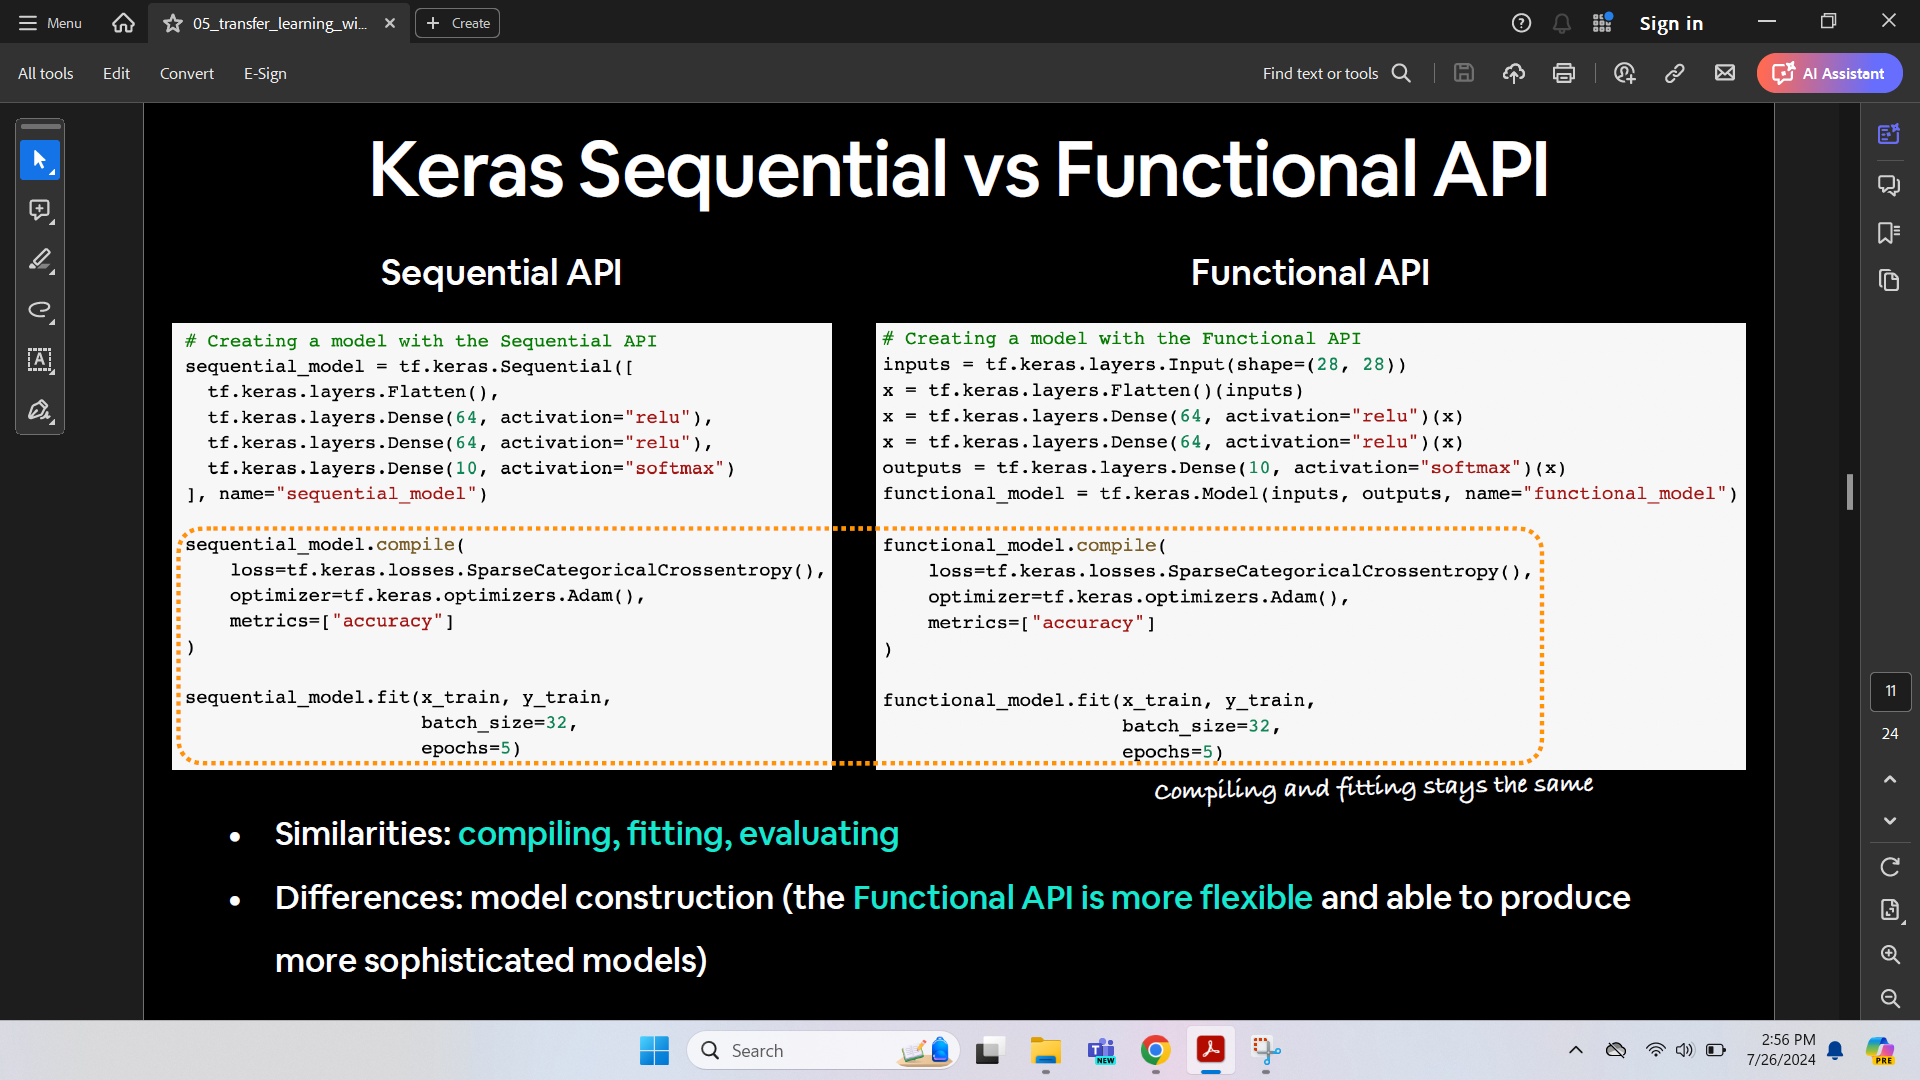

## Model 0: Building a transfer learning model using the Keras Functional API

In [ ]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224,224,3),
                               name = "input_layer")

# 4. If using ResNet50V2 we will need to normalize, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
print(f"Shape after passing input through base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback(dir_name = "transfer_learning",
                                                                        experiment_name = "10_percent_feature_extraction")])


Shape after passing input through base_model: (None, 7, 7, 1280)
Shape After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20240727-211919
Epoch 1/5
24/24 [==============================] - 17s 279ms/step - loss: 1.9006 - accuracy: 0.4160 - val_loss: 1.3148 - val_accuracy: 0.7319
Epoch 2/5
24/24 [==============================] - 4s 168ms/step - loss: 1.1564 - accuracy: 0.7467 - val_loss: 0.9009 - val_accuracy: 0.8010
Epoch 3/5
24/24 [==============================] - 4s 157ms/step - loss: 0.8546 - accuracy: 0.8293 - val_loss: 0.7183 - val_accuracy: 0.8207
Epoch 4/5
24/24 [==============================] - 4s 172ms/step - loss: 0.6980 - accuracy: 0.8587 - val_loss: 0.6298 - val_accuracy: 0.8273
Epoch 5/5
24/24 [==============================] - 4s 168ms/step - loss: 0.6010 - accuracy: 0.8653 - val_loss: 0.5587 - val_accuracy: 0.8586


In [ ]:
# evaluate on the test data
model_0.evaluate(test_data)

79/79 [==============================] - 7s 75ms/step - loss: 0.5724 - accuracy: 0.8520


[0.5723710656166077, 0.8519999980926514]

In [ ]:
# check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [ ]:
# lets explore the base model summary
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [ ]:
# Let's explore the summary of the complete Model
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

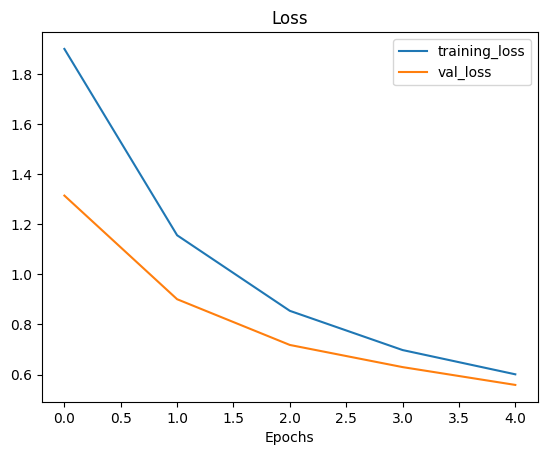

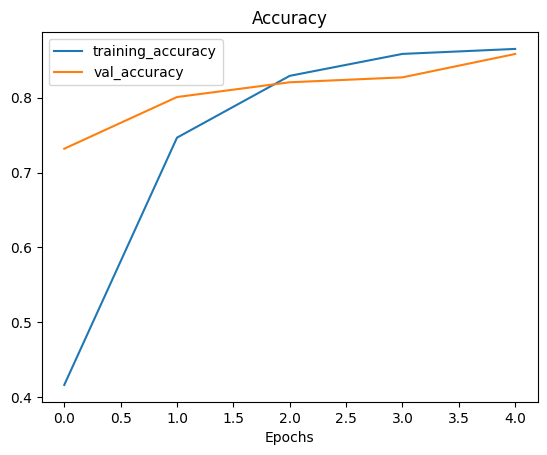

In [ ]:
# Look at the Model training curve
plot_loss_curves(history_10_percent)

## Getting a Feature Vector from a Trained Model

🤔 Question: What happens with the `tf.keras.layers.GlobalAveragePooling2D()` layer? We haven't seen it before.

WE have a tensor after our model goes through the `base_model` of shape (None, 7, 7, 1280). But when it passes through the `GlobalAveragePooling2D`, it turns into (None, 1280)

The `tf.keras.layers.GlobalAveragePooling2D()` layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes.

The previous sentence is a bit of a mouthful, so let's see an example.

In [ ]:
# define the input shape
input_shape = (1,4,4,3)

# create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor :\n {input_tensor}\n")

# pass the random tensor through a global average poolig 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor: \n {global_average_pooled_tensor} \n")

# check the shape of the different tensors
print(f"Shape of the input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor :
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor: 
 [[-0.09368646 -0.45840448 -0.2885598 ]] 

Shape of the input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [ ]:
## Lets replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

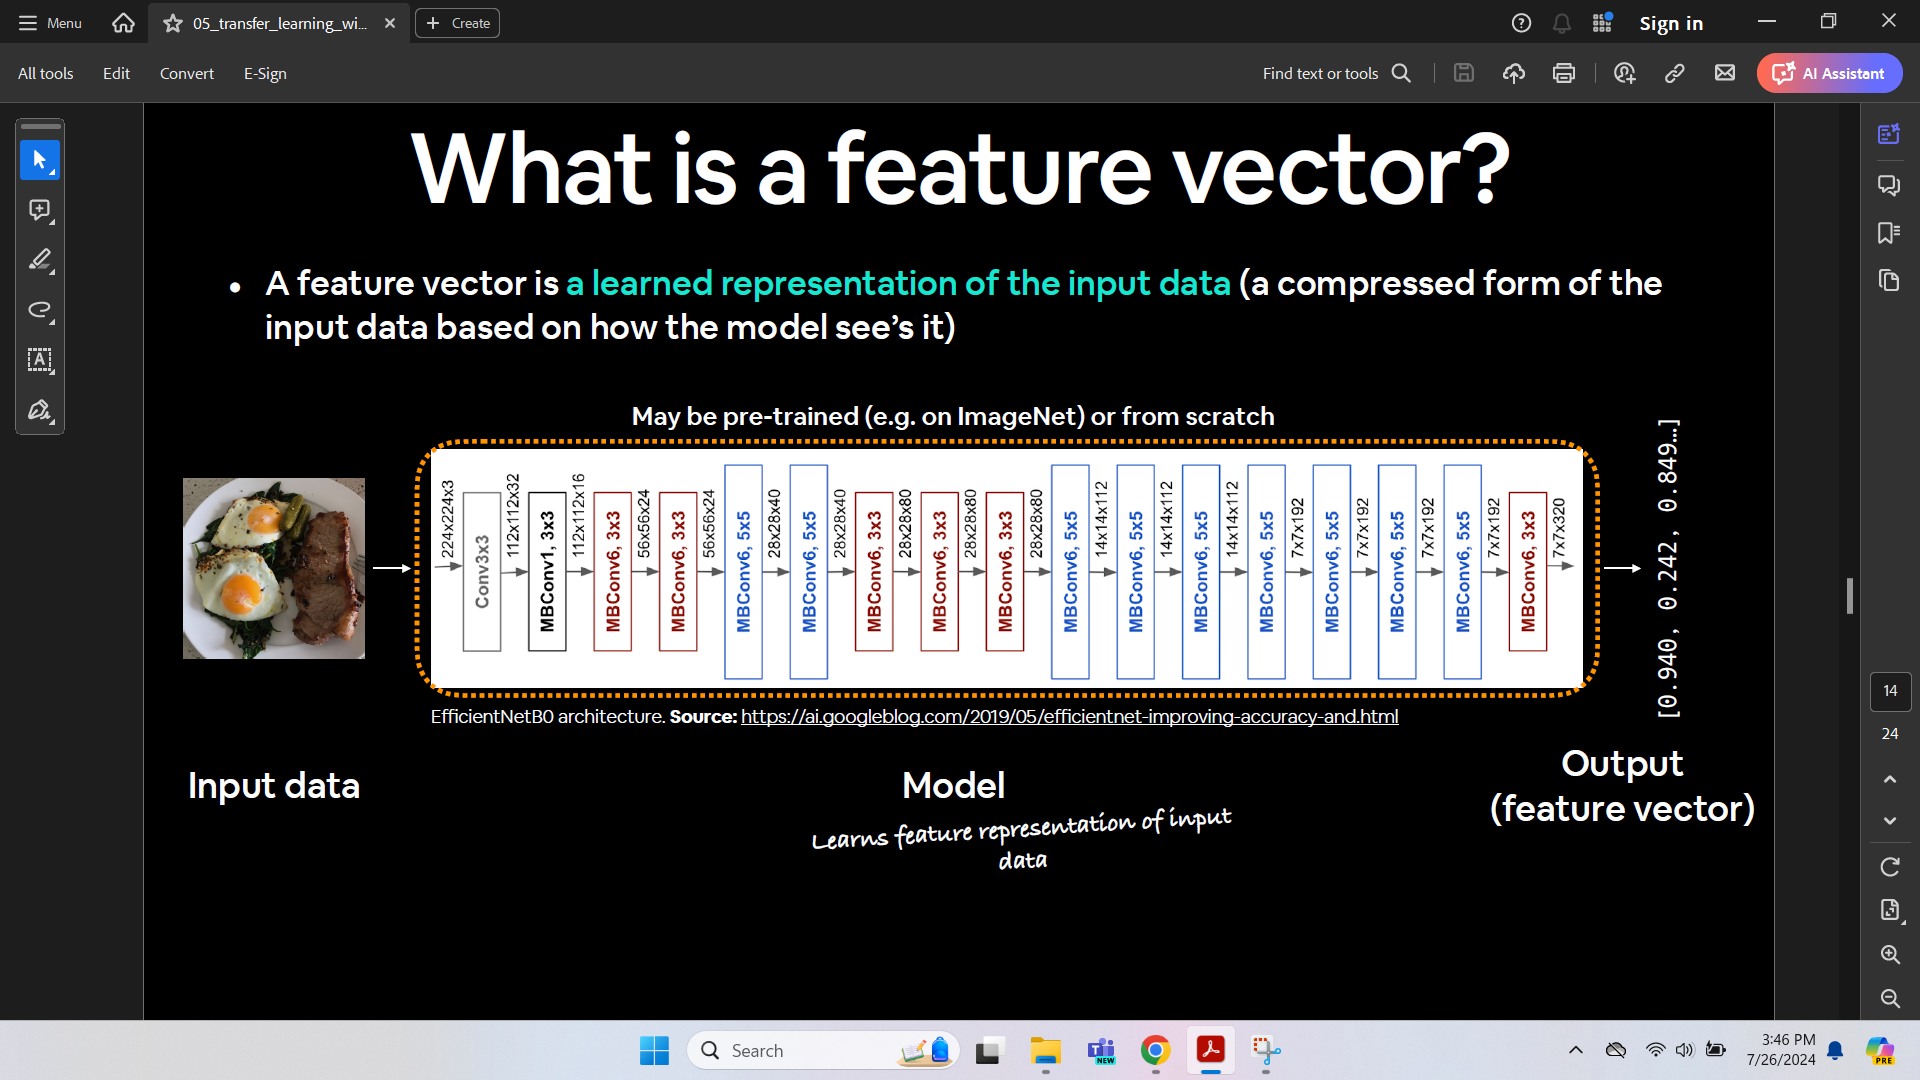

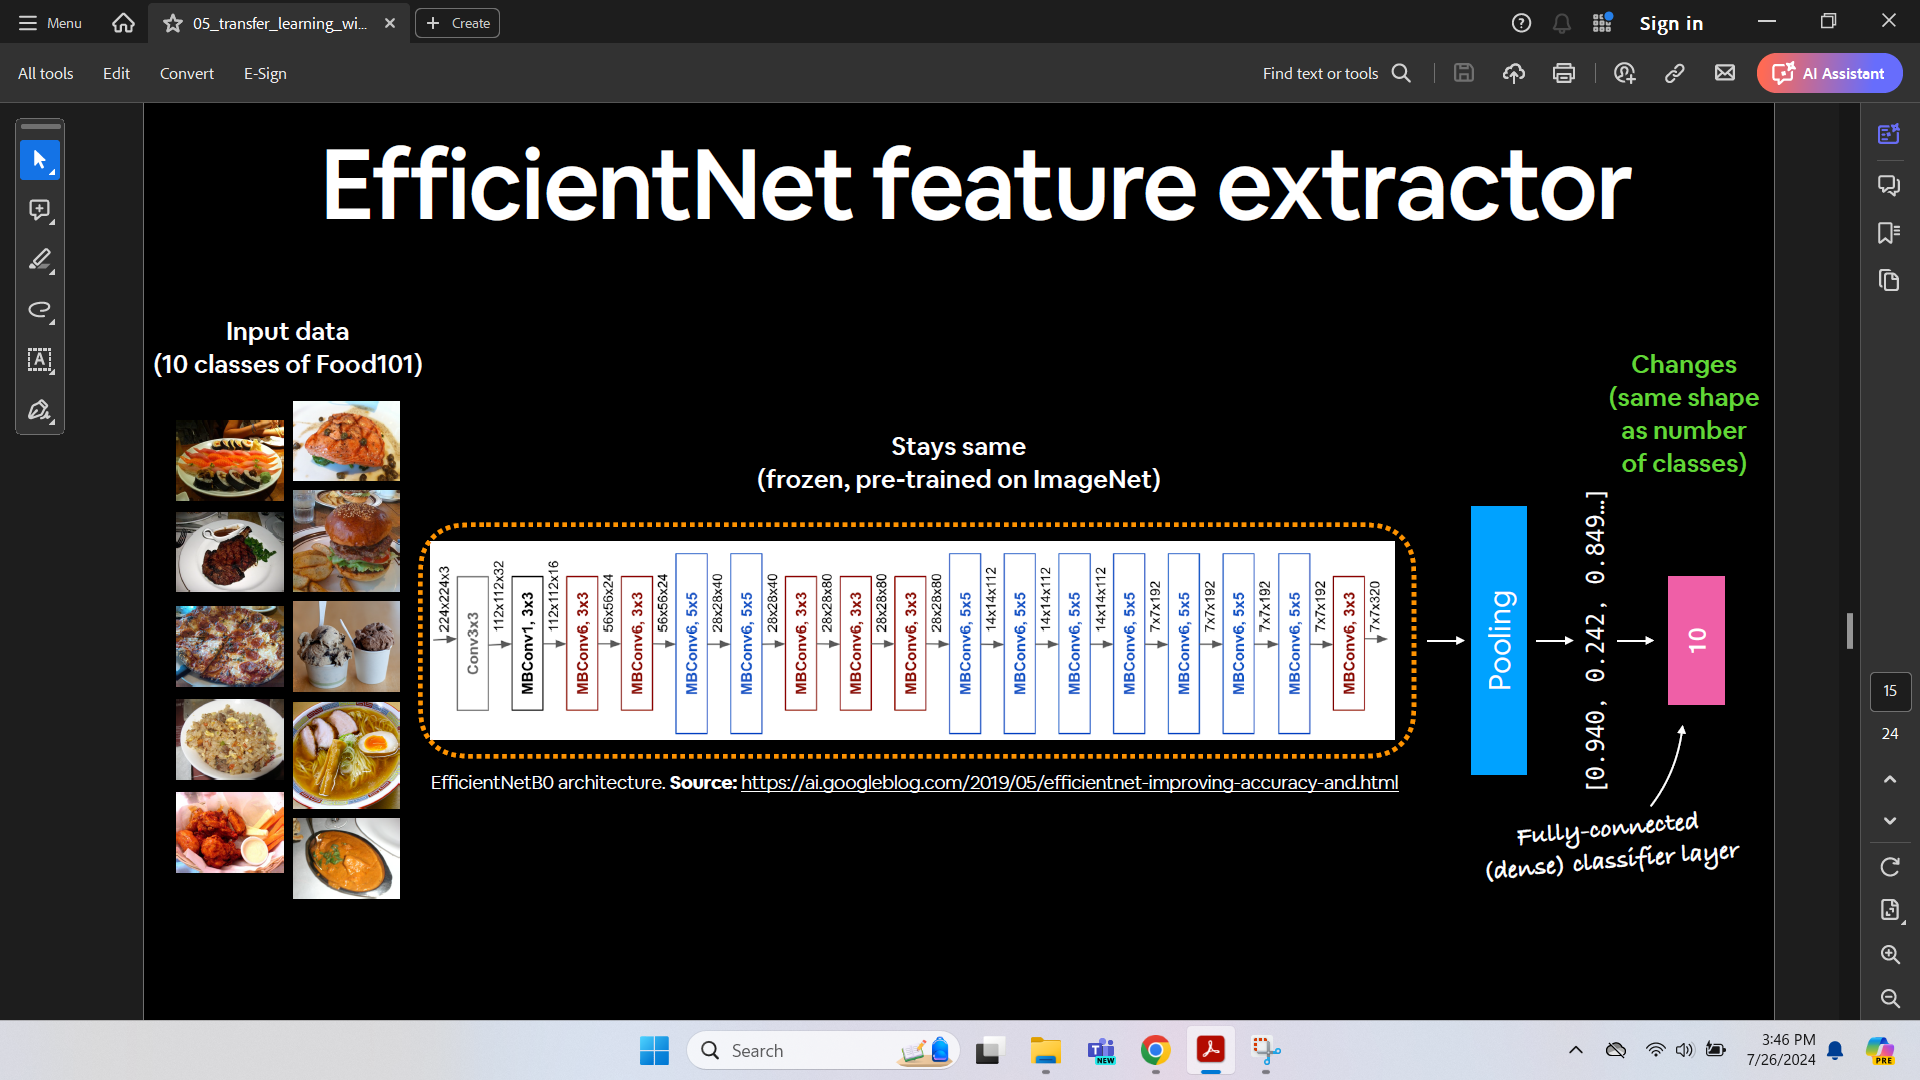

## Running a Series of Transfer Learning Experiments

We've seen the incredible results of transfer learning on 10% of the training data, what about 1% of the training data?

What kind of results do you think we can get using 100x less data than the original CNN models we built ourselves?

Why don't we answer that question while running the following modelling experiments:

- Model 1: Use feature extraction transfer learning on 1% of the training data with data augmentation.
- Model 2: Use feature extraction transfer learning on 10% of the training data with data augmentation and save the results to a checkpoint.
- Model 3: Fine-tune the Model 2 checkpoint on 10% of the training data with data augmentation.
- Model 4: Fine-tune the Model 2 checkpoint on 100% of the training data with data augmentation.

While all of the experiments will be run on different versions of the training data, they will all be evaluated on the same test dataset, this ensures the results of each experiment are as comparable as possible.

All experiments will be done using the EfficientNetV2B0 model within the tf.keras.applications.efficientnet_v2 module.

To make sure we're keeping track of our experiments, we'll use our create_tensorboard_callback() function to log all of the model training logs.

We'll construct each model using the Keras Functional API and instead of implementing data augmentation in the ImageDataGenerator class as we have previously, we're going to build it right into the model using the tf.keras.layers module.

Let's begin by downloading the data for experiment 1, using feature extraction transfer learning on 1% of the training data with data augmentation.

In [ ]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2024-07-27 21:20:09--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.3’

10_food_classes_1_p 100%[===================>] 127.42M   167MB/s    in 0.8s    

2024-07-27 21:20:10 (167 MB/s) - ‘10_food_classes_1_percent.zip.3’ saved [133612354/133612354]



In [ ]:
# how many images are we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'

## Model 1 (without data augmentation)

In [ ]:
# Setup the data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32


train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                            label_mode = "categorical",
                                                                            image_size = IMG_SIZE,
                                                                            batch_size= BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size = IMG_SIZE,
                                                                batch_size = BATCH_SIZE,
                                                                label_mode = "categorical")

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding Data Augmentation Right into the Model

Previously we've used the different parameters of the `ImageDataGenerator` class to augment our training images, this time we're going to build data augmentation right into the model.

How?

Using the `tf.keras.layers` module and creating a dedicated data augmentation layer.

This a relatively new feature added to TensorFlow 2.10+ but it's very powerful. Adding a data augmentation layer to the model has the following benefits:

Preprocessing of the images (augmenting them) happens on the GPU rather than on the CPU (much faster).
Images are best preprocessed on the GPU where as text and structured data are more suited to be preprocessed on the CPU.
Image data augmentation only happens during training so we can still export our whole model and use it elsewhere. And if someone else wanted to train the same model as us, including the same kind of data augmentation, they could.

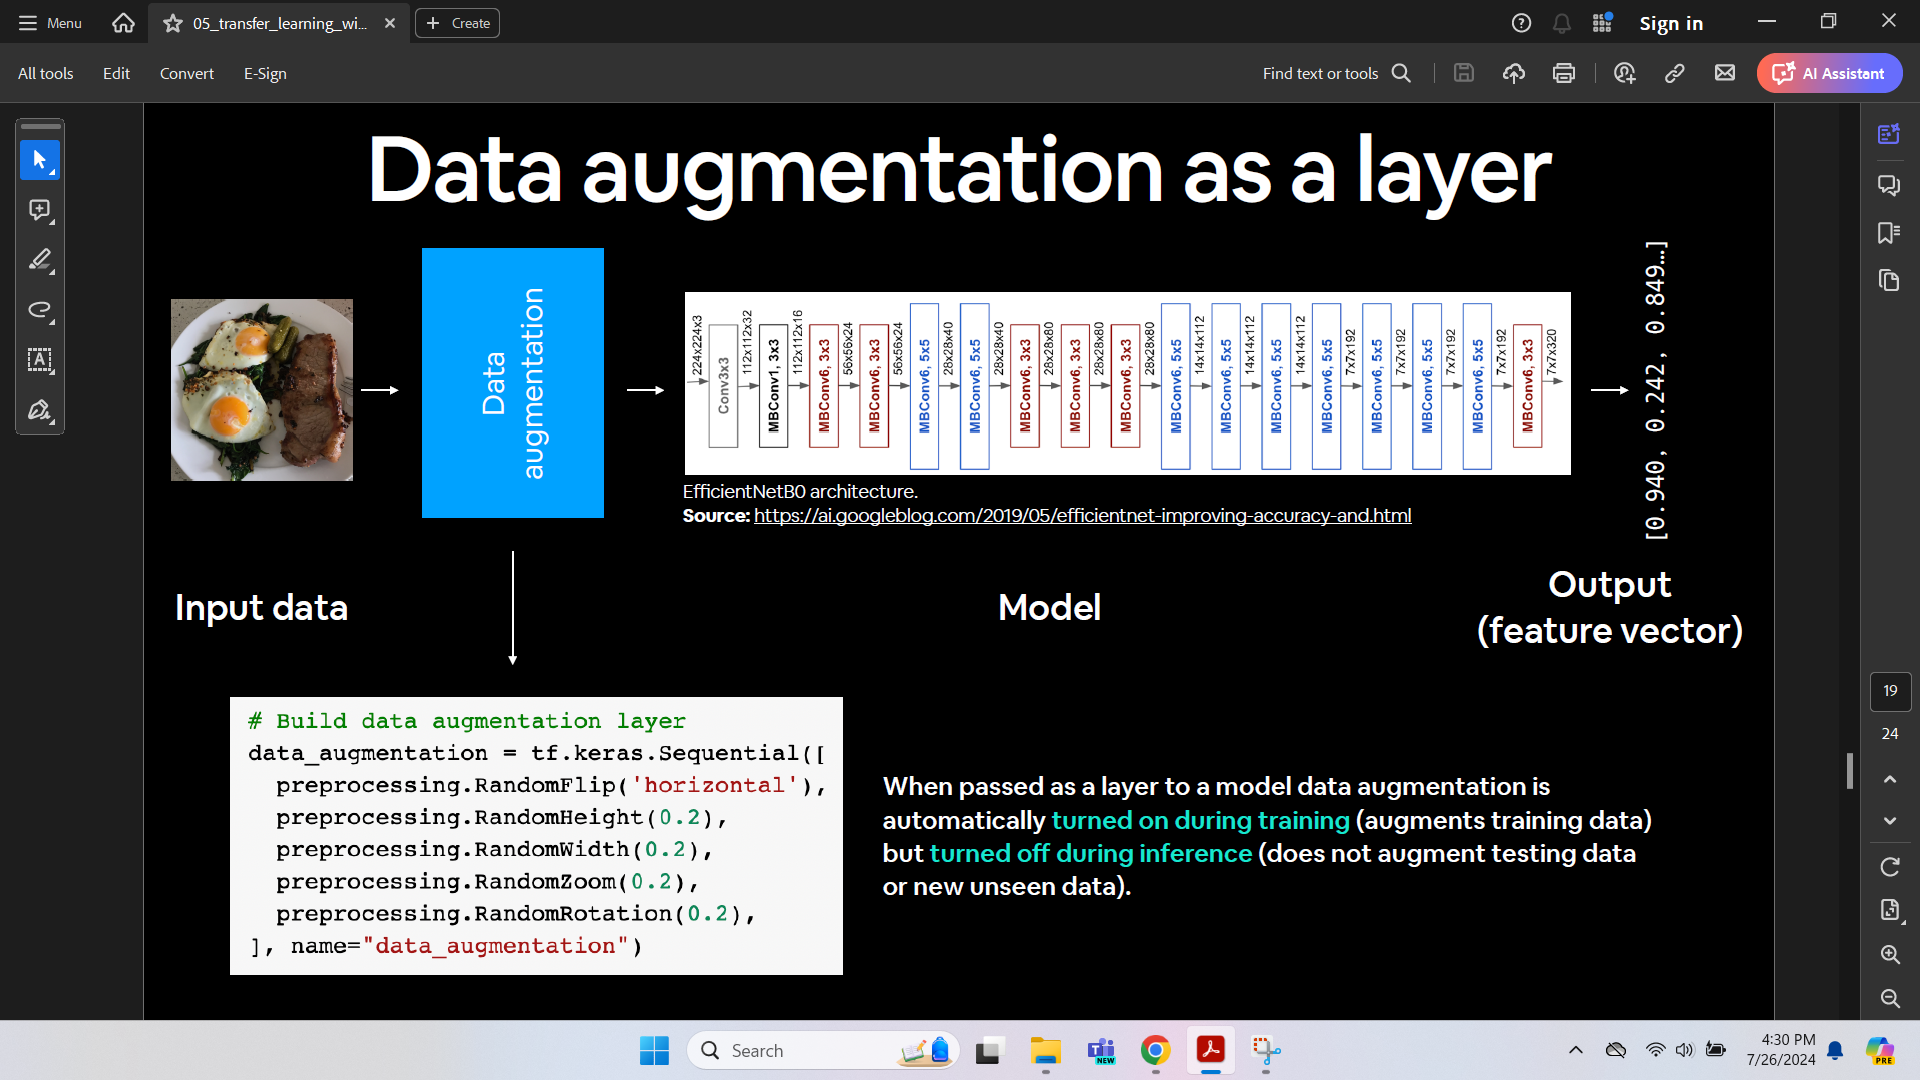



Example of using data augmentation as the first layer within a model (EfficientNetB0).

📚 Resource: For more information on different methods of data augmentation, check out the the [TensorFlow data augmentation guide](https://www.tensorflow.org/tutorials/images/data_augmentation).

To use data augmentation right within our model we'll create a Keras Sequential model consisting of only data preprocessing layers, we can then use this Sequential model within another Functional model.

If that sounds confusing, it'll make sense once we create it in code.

The data augmentation transformations we're going to use are:

- `tf.keras.layers.RandomFlip` - flips image on horizontal or vertical axis.
- `tf.keras.layersRandomRotation` - randomly rotates image by a specified amount.
- `tf.keras.layers.RandomZoom` - randomly zooms into an image by specified amount.
- `tf.keras.layers.RandomHeight` - randomly shifts image height by a specified amount.
- `tf.keras.layers.RandomWidth` - randomly shifts image width by a specified amount.
- `tf.keras.layers.Rescaling` - normalizes the image pixel values to be between 0 and 1, this is worth mentioning because it is required for some image models but since we're using `tf.keras.applications.efficientnet_v2`.EfficientNetV2B0, it's not required (the model pretrained model implements rescaling itself).
There are more option but these will do for now.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# create data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2) # keep for models like ResNet50V2 remove for EfficeentNet
], name="data_augmentation")

### Testing data Augmentation

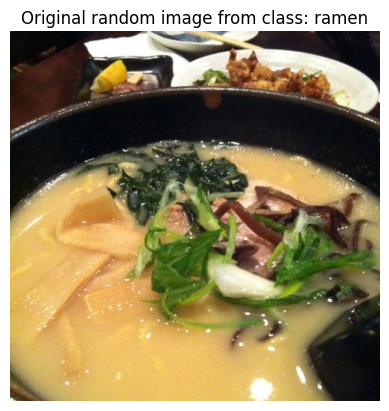

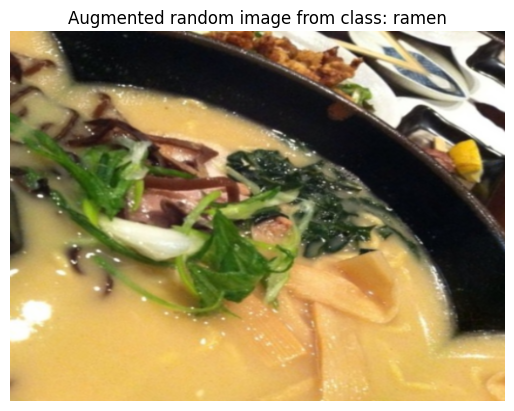

In [ ]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

# print an original image randomly
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes


# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);


## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [ ]:
# setup the input shape and base model, freezing the base model layers
input_shape = (224,224,3)
IMG_SIZE = 32

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# create input layer
inputs = layers.Input(shape=input_shape,
                      name="input_layers")

# add in data augmentation sequential model as a layer
x = data_augmentation(inputs)

# give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# pool output features of base model
x = layers.GlobalAveragePooling2D(name="gloabl_average_pooling_layer")(x)

# put a dense layer on as the output layer
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# make a complete model
model_1 = keras.Model(inputs, outputs)

# compile the model
model_1.compile(optimizer = tf.keras.optimizers.Adam(),
                loss = "categorical_crossentropy",
                metrics = ["accuracy"])

# fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs = 5,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25*len(test_data)),
                                callbacks = [create_tensorboard_callback("transfer_learning",
                                                                         "1_percent_data_aug")])




Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20240727-212017
Epoch 1/5
3/3 [==============================] - 16s 3s/step - loss: 2.3421 - accuracy: 0.1000 - val_loss: 2.2160 - val_accuracy: 0.1743
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.1083 - accuracy: 0.2429 - val_loss: 2.0876 - val_accuracy: 0.2582
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.9955 - accuracy: 0.4000 - val_loss: 2.0016 - val_accuracy: 0.3109
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.8258 - accuracy: 0.4714 - val_loss: 1.9012 - val_accuracy: 0.3964
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.6552 - accuracy: 0.6143 - val_loss: 1.8198 - val_accuracy: 0.4507


sing only 7 training images per class, using transfer learning our model was able to get ~45%+ accuracy on the validation set.

This result is pretty amazing since the original Food-101 paper achieved 50.67% accuracy with all the data, namely, 750 training images per class (note: this metric was across 101 classes, not 10, we'll get to 101 classes soon).

If we check out a summary of our model, we should see the data augmentation layer just after the input layer.

In [ ]:
# check the model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layers (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 gloabl_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

There it is. We've now got data augmentation built right into the our model. This means if we saved it and reloaded it somewhere else, the data augmentation layers would come with it.

The important thing to remember is **data augmentation** only runs during training. So if we were to evaluate or use our model for inference (predicting the class of an image) the data augmentation layers will be automatically turned off.

To see this in action, let's evaluate our model on the test data.

In [ ]:
# Evaluate the model on the complete test data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 71ms/step - loss: 1.8323 - accuracy: 0.4352


[1.8322982788085938, 0.4352000057697296]

The results here may be slightly better/worse than the log outputs of our model during training because during training we only evaluate our model on 25% of the test data using the line validation_steps=int(0.25 * len(test_data)). Doing this speeds up our epochs but still gives us enough of an idea of how our model is going.


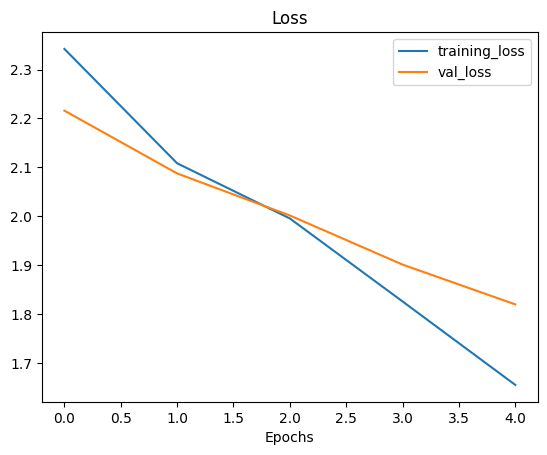

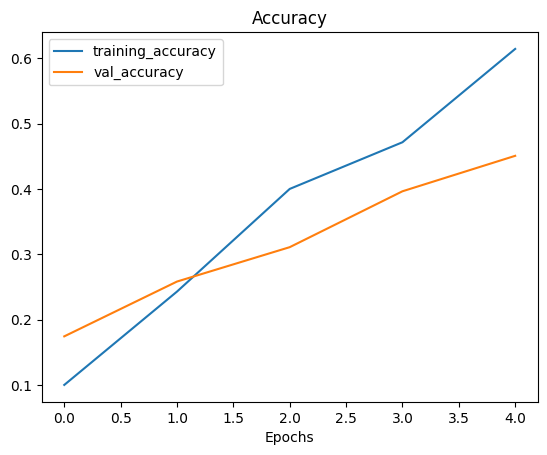

In [ ]:
# Plot loss curves
plot_loss_curves(history_1_percent)

## Model 2: Feature Extraction Transfer Learning model with 10% training data and Data Augmentation Built

In [ ]:
# Setup the training and testing directories
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
walk_through_dir(train_dir_10_percent)

There are 10 directories and 0 images in '10_food_classes_10_percent/train/'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.


In [ ]:
# Setup the Data Loaders Input
import tensorflow as tf
IMG_SIZE = (224,224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical",
                                                                            batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = "categorical",
                                                                batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# data augmentation layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
], name="data_augmentation")


# setup the input shape to our model
input_shape = (224, 224, 3)


# Create a frozen base model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

To save time for later (when we want to perform multiple experiments with model_2), let's put the code above into a function we can resuse.

### Creating a Model Checkpoint Callback
Our model is compiled and ready to be fit, so why haven't we fit it yet?

Well, for this experiment we're going to introduce a new callback, the ModelCheckpoint callback.

The `ModelCheckpoint` callback gives you the ability to save your model, as a whole in the SavedModel format or the [weights (patterns) only](https://www.tensorflow.org/tutorials/keras/save_and_load#manually_save_weights) to a specified directory as it trains.

This is helpful if you think your model is going to be training for a long time and you want to make backups of it as it trains. It also means if you think your model could benefit from being trained for longer, you can reload it from a specific checkpoint and continue training from there.

For example, say you fit a feature extraction transfer learning model for 5 epochs and you check the training curves and see it was still improving and you want to see if fine-tuning for another 5 epochs could help, you can load the checkpoint, unfreeze some (or all) of the base model layers and then continue training.


Let's create a ModelCheckpoint callback. To do so, we have to specifcy a directory we'd like to save to.

In [ ]:
# set checkpoint path
checkpoint_path = "ten_pecent_model_checkpoints_weights/checkpoints.ckpt"

# create a Model Checkpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only = True, # set to False to save the entire model
                                                         save_best_only = True,  # save only the best model weights instead of a model every epoch
                                                         save_freq = "epoch", # save every epoch
                                                         verbose=1)

🤔** Question: What's the difference between saving the entire model (SavedModel format) and saving the weights only?**

The SavedModel format saves a model's architecture, weights and training configuration all in one folder. It makes it very easy to reload your model exactly how it is elsewhere. However, if you do not want to share all of these details with others, you may want to save and share the weights only (these will just be large tensors of non-human interpretable numbers). If disk space is an issue, saving the weights only is faster and takes up less space than saving the whole model.

Time to fit the model.

Because we're going to be fine-tuning it later, we'll create a variable initial_epochs and set it to 5 to use later.

We'll also add in our checkpoint_callback in our list of callbacks.

In [ ]:
# Fit Model 2 passing int the model checkpoint callback
initial_epochs=5

history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs = initial_epochs,
                                          validation_data = test_data,
                                          validation_steps = int(0.25 * len(test_data)),
                                          callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                                   experiment_name = "10_percent_data_aug"),
                                                       checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20240727-212109
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0485 - accuracy: 0.3173
Epoch 1: val_loss improved from inf to 1.54565, saving model to ten_pecent_model_checkpoints_weights/checkpoints.ckpt
24/24 [==============================] - 37s 1s/step - loss: 2.0485 - accuracy: 0.3173 - val_loss: 1.5457 - val_accuracy: 0.6003
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.4124 - accuracy: 0.6467
Epoch 2: val_loss improved from 1.54565 to 1.11308, saving model to ten_pecent_model_checkpoints_weights/checkpoints.ckpt
24/24 [==============================] - 27s 1s/step - loss: 1.4124 - accuracy: 0.6467 - val_loss: 1.1131 - val_accuracy: 0.7023
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0986 - accuracy: 0.7413
Epoch 3: val_loss improved from 1.11308 to 0.90347, saving model to ten_pecent_model_checkpoints_weights/checkpoints.ckpt
24/24 [=======

In [ ]:
# What were model_0 results
model_0.evaluate(test_data)

79/79 [==============================] - 7s 69ms/step - loss: 0.5724 - accuracy: 0.8520


[0.5723711848258972, 0.8519999980926514]

In [ ]:
# Check model_2 results on all test dadta
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 5s 57ms/step - loss: 0.6884 - accuracy: 0.8092


[0.6883731484413147, 0.8091999888420105]

Adding in the data augmentation to our model, we can see that the model's performance decrease a little bit.

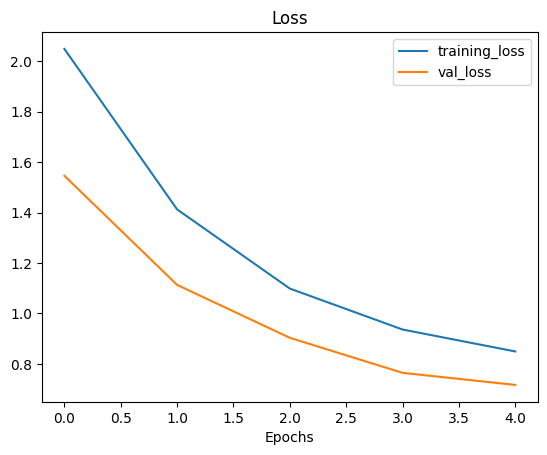

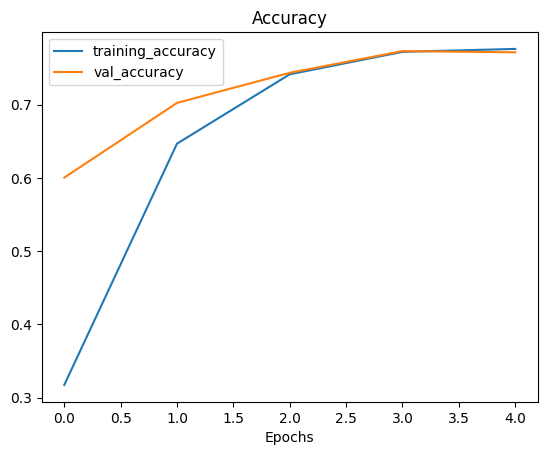

In [ ]:
# Plotting model loss curves
plot_loss_curves(history_10_percent_data_aug)

Looking at these, our model's performance with 10% of the data and data augmentation isn't as good as the model with 10% of the data without data augmentation (see `model_0` results above), however the curves are trending in the right direction, meaning if we decided to train for longer, its metrics would likely improve.

Since we checkpointed (is that a word?) our model's weights, we might as well see what it's like to load it back in. We'll be able to test if it saved correctly by evaluting it on the test data.

To load saved model weights you can use the the `load_weights()` method, passing it the path where your saved weights are stored.

# Loading In checkpointed weights
Loading in checkpointed weights retuns a model to a specific checkpoint.

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 7s 82ms/step - loss: 0.6884 - accuracy: 0.8092


In [ ]:
# if the results from our previouly evaluated model_2 match the loaded weights,everythin has worked
results_10_percent_data_aug == loaded_weights_model_results

False

In [ ]:
results_10_percent_data_aug

[0.6883731484413147, 0.8091999888420105]

In [ ]:
loaded_weights_model_results

[0.6883730292320251, 0.8091999888420105]

even though the results are almost same, we are getting the False result due to how computers save numbers. Thus, we will use Numpy to check is tow arrays are very close to each other, that should suffice for our use case.

In [ ]:
# Check to see if loaded model results are very close to our previos non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# Chcek the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[1.1920929e-07 0.0000000e+00]


## Model 3: Fine tuning an existing model on 10 percent data

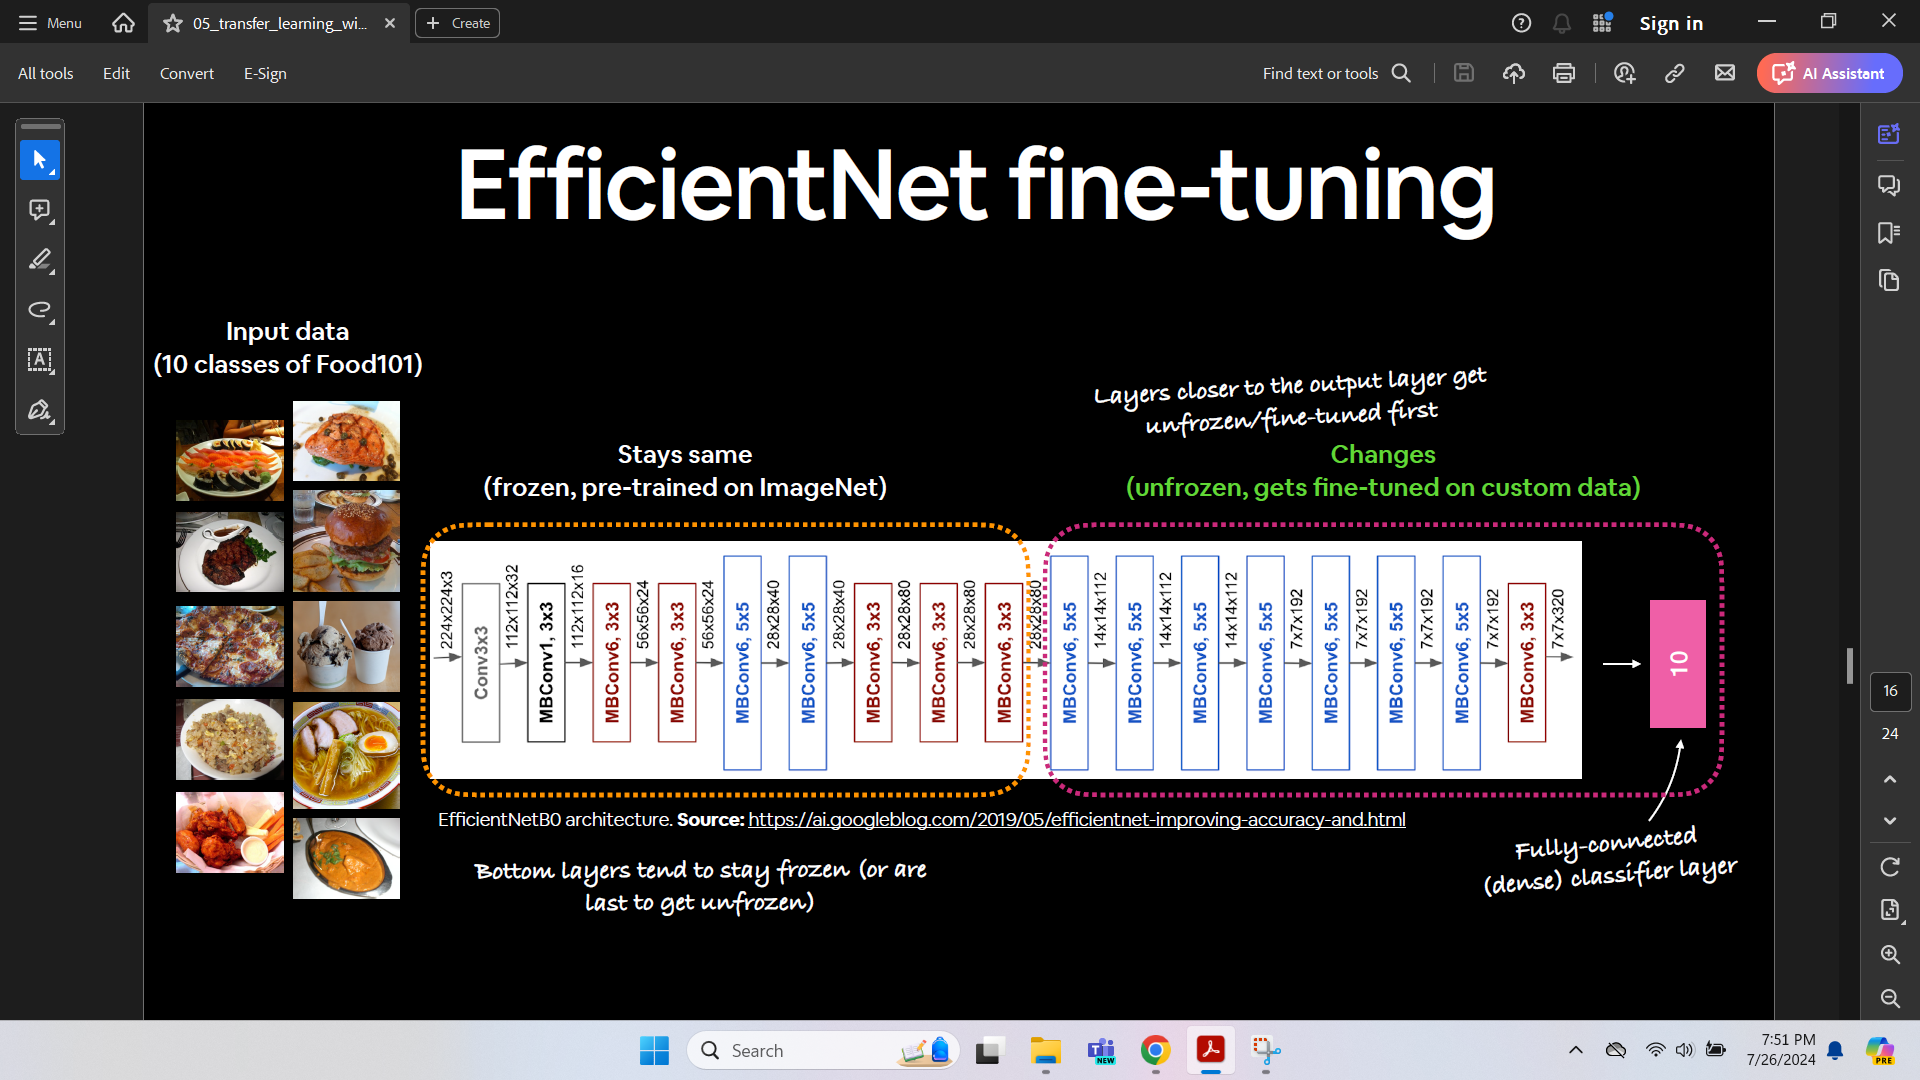

*High-level example of fine-tuning an EfficientNet model. Bottom layers (layers closer to the input data) stay frozen where as top layers (layers closer to the output data) are updated during training.*

So far our saved model has been trained using feature extraction transfer learning for 5 epochs on 10% of the training data and data augmentation.

This means all of the layers in the base model `(EfficientNetV2B0)` were frozen during training.

For our next experiment we're going to switch to fine-tuning transfer learning. This means we'll be using the same base model except we'll be unfreezing some of its layers (ones closest to the top) and running the model for a few more epochs.

The idea with fine-tuning is to start customizing the pre-trained model more to our own data.

🔑 Note: Fine-tuning usually works best after training a feature extraction model for a few epochs and with large amounts of data. For more on this, check out [Keras' guide on Transfer learning & fine-tuning](https://keras.io/guides/transfer_learning/).

We've verified our loaded model's performance, let's check out its layers.

In [ ]:
# layers in our loaded model
model_2.layers

In [ ]:
# are these layers trainable
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7e6e7d392950> True
<keras.src.engine.sequential.Sequential object at 0x7e6e7cba4400> True
<keras.src.engine.functional.Functional object at 0x7e6e7d295390> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7e6e7d2132e0> True
<keras.src.layers.core.dense.Dense object at 0x7e6e7d295990> True


In [ ]:
# What layers are in our base_model (EfficientNetB0) and are they trainable
for i,layer in enumerate(model_2.layers[2].layers):
   print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

Beautiful. This is exactly what we're after.

Now to fine-tune the base model to our own data, we're going to unfreeze the top 10 layers and continue training our model for another 5 epochs.

This means all of the base model's layers except for the last 10 will remain frozen and untrainable. And the weights in the remaining unfrozen layers will be updated during training.

Ideally, we should see the model's performance improve.

🤔 Question: How many layers should you unfreeze when training?

There's no set rule for this. You could unfreeze every layer in the pretrained model or you could try unfreezing one layer at a time. Best to experiment with different amounts of unfreezing and fine-tuning to see what happens. Generally, the less data you have, the less layers you want to unfreeze and the more gradually you want to fine-tune.

📖 Resource: The [ULMFiT (Universal Language Model Fine-tuning for Text Classification) paper](https://arxiv.org/abs/1801.06146) has a great series of experiments on fine-tuning models.

To begin fine-tuning, we'll unfreeze the entire `model_2_base_model` by setting its `trainable` attribute to `True`.

Then we'll refreeze every layer in `model_2_base_model` except for the last 10 by looping through them and setting their `trainable` attribute to `False`.

Finally, we'll recompile the whole model.

In [ ]:
# Access the base_model layers of model_2
model_2_base_model = model_2.layers[2]
model_2_base_model.name

'efficientnetv2-b0'

In [ ]:
# How many trainable variables in our base model?
print(len(model_2_base_model.trainable_variables))

0


In [ ]:
# To begin fine tuning, let's start by setting the last 10 layers of our base_model.trainable=True
# base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
model_2_base_model.trainable = True

# Freeze all layers except for the last 10
for layer in model_2_base_model.layers[:-10]:
  layer.trainable=False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), # wehen fine tuning, we typically want to lower the learning rate by 10x
                metrics = ["accuracy"])

since, we are tuning already learned weight, WE DO NOT WANT THEM TO UPDATE TOO MUCH. So, we lower the learning rate of our optimizer.

In [ ]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

Nice! It seems all layers except for the last 10 are frozen and untrainable. This means only the last 10 layers of the base model along with the output layer will have their weights updated during training.

🤔 Question: Why did we recompile the model?

Every time you make a change to your models, you need to recompile them.

In our case, we're using the exact same loss, optimizer and metrics as before, except this time the learning rate for our optimizer will be 10x smaller than before (0.0001 instead of Adam's default of 0.001).

We do this so the model doesn't try to overwrite the existing weights in the pretrained model too fast. In other words, we want learning to be more gradual.

🔑 Note: There's no set standard for setting the learning rate during fine-tuning, though reductions of [2.6x-10x+ seem to work well in practice](https://arxiv.org/abs/1801.06146).

How many trainable variables do we have now?

In [ ]:
print(len(model_2.trainable_variables))

12


Wonderful, it looks like our model has a total of 12 trainable variables, the last 10 layers of the base model and the weight and bias parameters of the Dense output layer.

Time to fine-tune!

We're going to continue training on from where our previous model finished. Since it trained for 5 epochs, our fine-tuning will begin on the epoch 5 and continue for another 5 epochs.

To do this, we can use the `initial_epoch` parameter of the `fit()` method. We'll pass it the last epoch of the previous model's training history (`history_10_percent_data_aug.epoch[-1]`).

In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch = history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               callbacks=[create_tensorboard_callback("transfer_learning",
                                                                                      "10_percent_fine_tune_last_10")]) # name experiment appropriately


Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20240727-212439
Epoch 5/10
24/24 [==============================] - 33s 921ms/step - loss: 0.7131 - accuracy: 0.7880 - val_loss: 0.5468 - val_accuracy: 0.8125
Epoch 6/10
24/24 [==============================] - 19s 764ms/step - loss: 0.6096 - accuracy: 0.8160 - val_loss: 0.5154 - val_accuracy: 0.8141
Epoch 7/10
24/24 [==============================] - 18s 738ms/step - loss: 0.5439 - accuracy: 0.8333 - val_loss: 0.4775 - val_accuracy: 0.8322
Epoch 8/10
24/24 [==============================] - 17s 695ms/step - loss: 0.5277 - accuracy: 0.8360 - val_loss: 0.4859 - val_accuracy: 0.8224
Epoch 9/10
24/24 [==============================] - 16s 643ms/step - loss: 0.4734 - accuracy: 0.8533 - val_loss: 0.4993 - val_accuracy: 0.8224
Epoch 10/10
24/24 [==============================] - 19s 784ms/step - loss: 0.4338 - accuracy: 0.8613 - val_loss: 0.4639 - val_accuracy: 0.8289


🔑 Note: Fine-tuning usually takes far longer per epoch than feature extraction (due to updating more weights throughout a network).

Ho ho, looks like our model has gained a few percentage points of accuracy! Let's evalaute it.

In [ ]:
# evaluate the model on complete test data
results_fine_tune_10_percent = model_2.evaluate(test_data)
results_fine_tune_10_percent

79/79 [==============================] - 5s 58ms/step - loss: 0.4487 - accuracy: 0.8492


[0.4487123489379883, 0.8492000102996826]

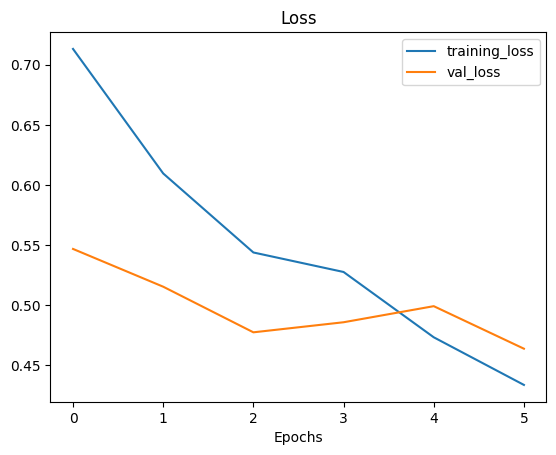

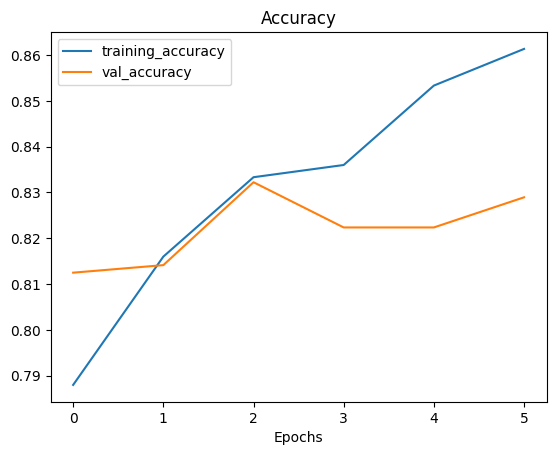

In [ ]:
# plot loss curves
plot_loss_curves(history_fine_10_percent_data_aug)

The above training plots are only for the first 5 epochs, but our model has been trained for 10 epochs. We need to plot the model model training curve before and after fine tuning.

### Compare the history of model Training before and after fine tuning

In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.3173333406448364, 0.6466666460037231, 0.7413333058357239, 0.7720000147819519, 0.7760000228881836, 0.7879999876022339, 0.8159999847412109, 0.8333333134651184, 0.8360000252723694, 0.8533333539962769, 0.8613333106040955]


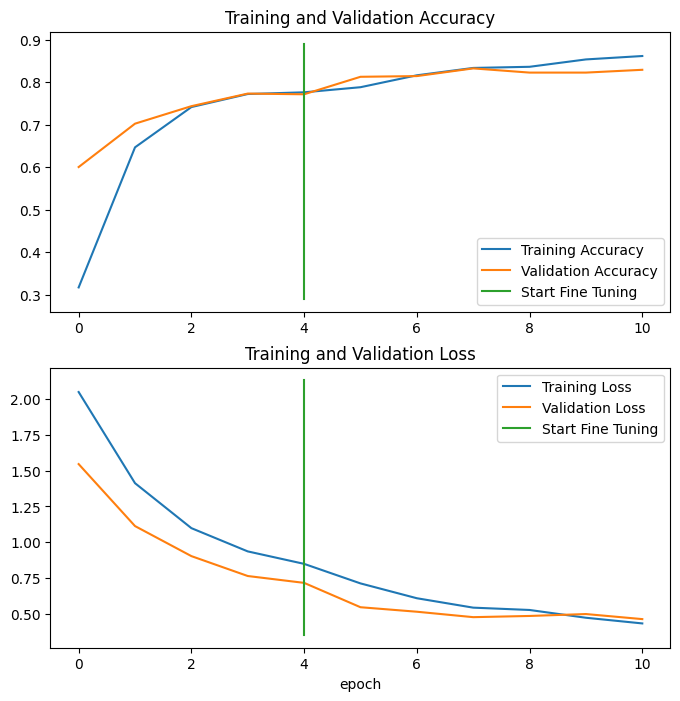

In [ ]:

compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_percent_data_aug,
                 initial_epochs=5)

## Model 4

In [ ]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2024-07-27 21:26:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.2’

10_food_classes_all 100%[===================>] 495.13M  27.4MB/s    in 6.0s    

2024-07-27 21:26:55 (82.3 MB/s) - ‘10_food_classes_all_data.zip.2’ saved [519183241/519183241]



In [ ]:
# look at the numner of files in our dataset currently
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 

In [ ]:
# Setup training and Testing directories
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [ ]:
# setup data inputs
import tensorflow as tf

IMG_SIZE = (224,224)

# training data inputs
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode = "categorical",
                                                                                 image_size = IMG_SIZE,
                                                                                 batch_size=32)
# testing data inputs
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                batch_size=32)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset is the same we've been using for our previous experiments.

As it is now, our model_2 has been fine-tuned on 10 percent of the data, so to begin fine-tuning on all of the data and keep our experiments consistent, we need to revert it back to the weights we checkpointed after 5 epochs of feature-extraction.

To demonstrate this, we'll first evaluate the current model_2.

In [ ]:
# evaluate model 2 (this is the fine tuned on 10% of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 6s 60ms/step - loss: 0.4487 - accuracy: 0.8492


[0.44871243834495544, 0.8492000102996826]

In [ ]:
results_fine_tune_10_percent

[0.4487123489379883, 0.8492000102996826]

To keep our experiments clean, we'll load a create a new instance of model_2 using our create_base_model() function.

More specifically, we're trying to measure:

Experiment 3 (previous one) - model_2 with 10 layers fine-tuned for 5 more epochs on 10% of the data.
Experiment 4 (this one) - model_2 with layers fined-tuned for 5 more epochs on 100% on the data.
Importantly, both experiments should use the same test data (to keep evaluation the same).

And they should also start from the same checkpoint (model_2 feature extractor trained for 5 epochs on 10% of the data).

Let's first create new instance of model_2.



To train a fine-tuning model (model 4) we need to revert model2 back to its feature extraction weights. We can do this by loading the model through its checkpoint weights.

In [ ]:

def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

In [ ]:
# Create a new instance of model_2 for Experiment 4
model_2 = create_base_model(learning_rate=0.0001) # 10x lower learning rate for fine-tuning

And now to make sure it starts at the same checkpoint, we can load the checkpointed weights from checkpoint_path

In [ ]:
# Load previously checkpointed weights
model_2.load_weights(checkpoint_path)

In [ ]:
# let's re-evalute the loaded model_2 (it shouls have worse performance than our previous result)
model_2.evaluate(test_data)

79/79 [==============================] - 9s 60ms/step - loss: 0.6884 - accuracy: 0.8092


[0.6883729696273804, 0.8091999888420105]

In [ ]:
model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [ ]:
# look at the number of trainable layers in our model2
print(len(model_2.trainable_variables))

2


Alright, the previous steps might seem quite confusing but all we've done is:

- Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using ModelCheckpoint (Model 2).
- Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (Model 3).
- Saved the results and training logs each time.
- Reloaded the model from 1 to do the same steps as 2 but with all (100%) of the data (Model 4).
The same steps as 2?

Yeah, we're going to fine-tune the last 10 layers of the base model with the full dataset for another 5 epochs but first let's remind ourselves which layers are trainable.

In [ ]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 False
3 global_average_pooling_layer True
4 output_layer True


In [ ]:
# let's look at the trainable layers in our efficientnet model
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [ ]:
# let us unfreeze the top 10 layers in model'2 base_model
model_2_base_model = model_2.layers[2]
model_2_base_model.trainable=True

# Freeze all the layers except the last 10
for layers in model_2_base_model.layers[:-10]:
  layer.trainable = False

In [ ]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(model_2_base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 True
1 rescaling_3 True
2 normalization_3 True
3 stem_conv True
4 stem_bn True
5 stem_activation True
6 block1a_project_conv True
7 block1a_project_bn True
8 block1a_project_activation True
9 block2a_expand_conv True
10 block2a_expand_bn True
11 block2a_expand_activation True
12 block2a_project_conv True
13 block2a_project_bn True
14 block2b_expand_conv True
15 block2b_expand_bn True
16 block2b_expand_activation True
17 block2b_project_conv True
18 block2b_project_bn True
19 block2b_drop True
20 block2b_add True
21 block3a_expand_conv True
22 block3a_expand_bn True
23 block3a_expand_activation True
24 block3a_project_conv True
25 block3a_project_bn True
26 block3b_expand_conv True
27 block3b_expand_bn True
28 block3b_expand_activation True
29 block3b_project_conv True
30 block3b_project_bn True
31 block3b_drop True
32 block3b_add True
33 block4a_expand_conv True
34 block4a_expand_bn True
35 block4a_expand_activation True
36 block4a_dwconv2 True
37 block4a_bn True
38 block4a_a

In [ ]:

# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])

In [ ]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])


Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20240727-212728
Epoch 5/10
235/235 [==============================] - 534s 2s/step - loss: 0.5759 - accuracy: 0.8123 - val_loss: 0.2776 - val_accuracy: 0.9178
Epoch 6/10
235/235 [==============================] - 375s 2s/step - loss: 0.3555 - accuracy: 0.8863 - val_loss: 0.2553 - val_accuracy: 0.9194
Epoch 7/10
235/235 [==============================] - 306s 1s/step - loss: 0.2633 - accuracy: 0.9107 - val_loss: 0.2371 - val_accuracy: 0.9227
Epoch 8/10
235/235 [==============================] - 294s 1s/step - loss: 0.1990 - accuracy: 0.9331 - val_loss: 0.2245 - val_accuracy: 0.9178
Epoch 9/10
235/235 [==============================] - 256s 1s/step - loss: 0.1572 - accuracy: 0.9500 - val_loss: 0.1703 - val_accuracy: 0.9490
Epoch 10/10
235/235 [==============================] - 209s 892ms/step - loss: 0.1321 - accuracy: 0.9564 - val_loss: 0.2003 - val_accuracy: 0.9375


In [ ]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 5s 57ms/step - loss: 0.2321 - accuracy: 0.9260


[0.2320641428232193, 0.9259999990463257]

In [ ]:
results_fine_tune_10_percent

[0.4487123489379883, 0.8492000102996826]

5
11
[0.3173333406448364, 0.6466666460037231, 0.7413333058357239, 0.7720000147819519, 0.7760000228881836, 0.8122666478157043, 0.8862666487693787, 0.9106666445732117, 0.9330666661262512, 0.949999988079071, 0.9563999772071838]


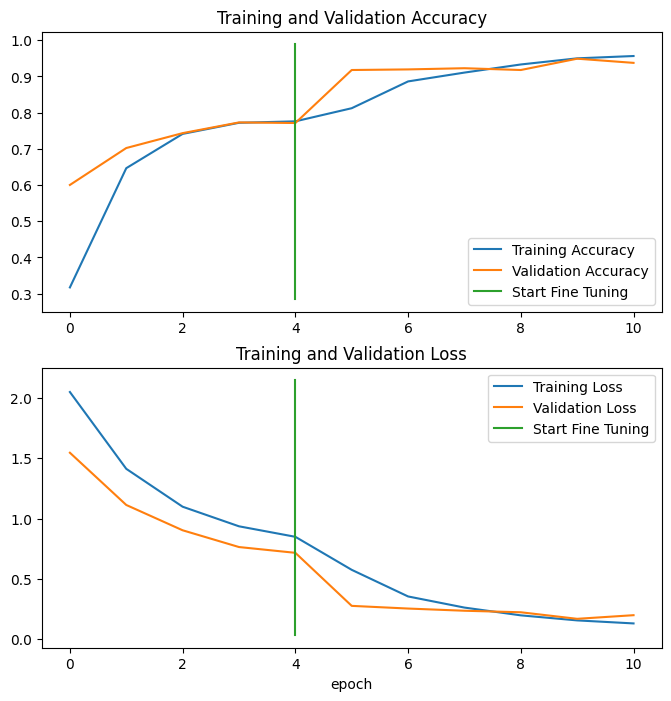

In [ ]:

# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)
